# Load Packages

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
import torch.nn.functional as F
import copy
from ipykernel import kernelapp as app
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Loading Datset

In [0]:
batch_size=16
epochs = 25


transforms=transforms.Compose([transforms.ToTensor()])
train_set = dataset.MNIST(root='./data',train=True, 
                           download=True,transform=transforms)
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True,num_workers=0)
test_set = dataset.MNIST(root='/data', train=False,
                        download=True, transform=transforms)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,shuffle=True,num_workers=0)


# Simple Autoencoders

In [0]:
class autoencoder(nn.Module):                          #Code Referenced from: 
    def  __init__(self):                               #https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(                  #The encoder layer
            nn.Conv2d(1, 32, 3, stride=3, padding=1),  #Calculates convolutions in batches, with stride and padding.
            nn.ReLU(True),                             #Relu acting as activation function
            nn.MaxPool2d(2, stride=2),                 #Implements a filter of 2x2 with stride 2. used to reduce matrix size.
            
                                                       #Start of Encoder Layer #2
            nn.Conv2d(32, 16, 3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  
                                    )
        
        
        
        
        self.decoder = nn.Sequential(                   #The Decoder Layer
            nn.ConvTranspose2d(16, 32, 3, stride=2),    #Calculates Transpose of convolutions in batches, with stride and padding.
            nn.ReLU(True),                              #Activation Function 
            
                                                        #Decoder Layer #2
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),                                            
            nn.ReLU(True),
                                                        #Decoder Layer #3
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),  
            nn.Tanh()
                                  
                                    )
        
    def forward(self,x):
        x =self.encoder(x)
        x = self.decoder(x)
        return x
      
      
    

In [0]:
net = autoencoder().cuda()
init_weights = copy.deepcopy(net.encoder[0].weight.data)

In [80]:
init_weights

tensor([[[[-0.0002,  0.1449, -0.0754],
          [-0.1297,  0.2350, -0.1081],
          [-0.0082,  0.1838,  0.2995]]],


        [[[-0.1157,  0.3147,  0.1153],
          [ 0.2086, -0.3312, -0.1743],
          [ 0.2545,  0.3153, -0.0680]]],


        [[[-0.2045,  0.1880,  0.1172],
          [ 0.1335, -0.1885,  0.1090],
          [-0.3199, -0.0256,  0.0153]]],


        [[[ 0.3196, -0.0834, -0.0225],
          [-0.0745, -0.2258, -0.0009],
          [ 0.2313,  0.0232, -0.3051]]],


        [[[-0.0038,  0.3190, -0.3325],
          [ 0.1155, -0.0333, -0.2456],
          [-0.1781, -0.1882, -0.2921]]],


        [[[-0.0665, -0.2597,  0.2378],
          [ 0.2607, -0.0830, -0.2803],
          [ 0.0417,  0.2794,  0.1149]]],


        [[[-0.0364, -0.1269,  0.3123],
          [ 0.1954, -0.1208, -0.1986],
          [-0.0955, -0.1148, -0.1883]]],


        [[[ 0.1358,  0.0155, -0.2059],
          [-0.1437,  0.1128, -0.0637],
          [-0.0243, -0.0470,  0.2007]]],


        [[[-0.0881, -0.1390, -0.

# Noise Adder

In [0]:
def add_noise(img):                               #Adds Noise into the image using torch.randn() function
      noise = torch.randn(img.size()) * 0.2       # 0.2 acts as co-effecient for noise. The greater the more noise.
      noisy_img = img + noise
      return noisy_img

# optimization technique

In [0]:
import torch.optim as optim     

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)   #Learning Rate defined here as 0.5


In [83]:
dataiter=iter(train_loader)        # Data loader, loads training images
image,_=dataiter.next()
image.view(image.size(0),-1).shape

torch.Size([16, 784])

In [84]:
for epoch in range(epochs):             # Main Epoch Loop
    running_loss = 0                    # Loss counter
    for data in (train_loader):         # Runs for each image in training Dataset
        image,_=data
        
        noisy_image = add_noise(image)  # Adds noise into the image
        optimizer.zero_grad()
        
        inputs = Variable(noisy_image).cuda()
        image = Variable(image).cuda()
        
        outputs = net(inputs)
        loss = criterion(outputs,image) #image is the original image, outputs contains the noisy image. Sent for training.
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]   #Sums loss for each training image in training dataset.
    print('At Iteration : %d   ;  Mean-Squared Error : %f'%(epoch + 1,running_loss/
                                                                (train_set.train_data.size(0)/batch_size)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


At Iteration : 1   ;  Mean-Squared Error : 0.034589
At Iteration : 2   ;  Mean-Squared Error : 0.024821
At Iteration : 3   ;  Mean-Squared Error : 0.023310
At Iteration : 4   ;  Mean-Squared Error : 0.022430
At Iteration : 5   ;  Mean-Squared Error : 0.021725
At Iteration : 6   ;  Mean-Squared Error : 0.021330
At Iteration : 7   ;  Mean-Squared Error : 0.021037
At Iteration : 8   ;  Mean-Squared Error : 0.020725
At Iteration : 9   ;  Mean-Squared Error : 0.020514
At Iteration : 10   ;  Mean-Squared Error : 0.020329
At Iteration : 11   ;  Mean-Squared Error : 0.020182
At Iteration : 12   ;  Mean-Squared Error : 0.020050
At Iteration : 13   ;  Mean-Squared Error : 0.019934
At Iteration : 14   ;  Mean-Squared Error : 0.019873
At Iteration : 15   ;  Mean-Squared Error : 0.019768
At Iteration : 16   ;  Mean-Squared Error : 0.019685
At Iteration : 17   ;  Mean-Squared Error : 0.019639
At Iteration : 18   ;  Mean-Squared Error : 0.019572
At Iteration : 19   ;  Mean-Squared Error : 0.019510
At

In [0]:
dataiter=iter(test_loader)                 #Test Dataset Loader
test_image,_=dataiter.next()

noisy_image = add_noise(test_image)        #Adding Noise to test image

input_image = Variable(noisy_image).cuda()
test_image = Variable(test_image).cuda()
noisy_image= noisy_image.view(-1,28,28)
test_image= test_image.view(-1,28,28)

In [86]:
test_image.shape

torch.Size([16, 28, 28])

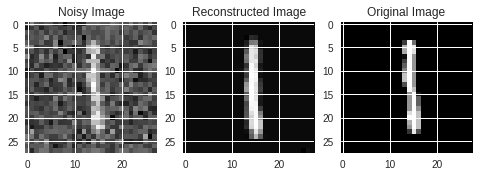

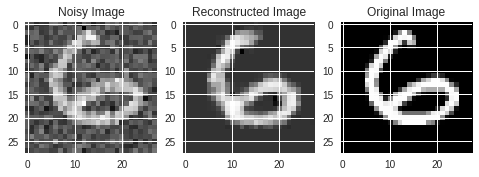

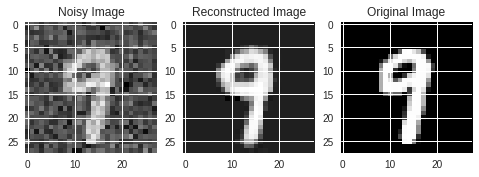

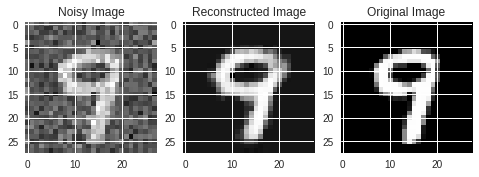

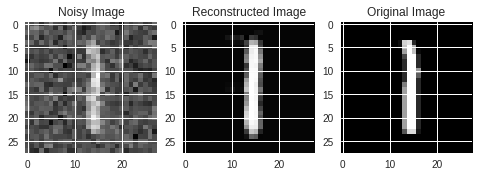

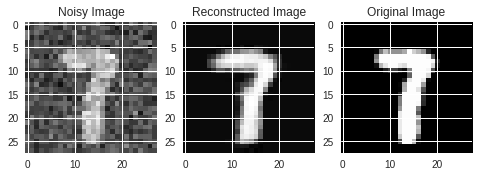

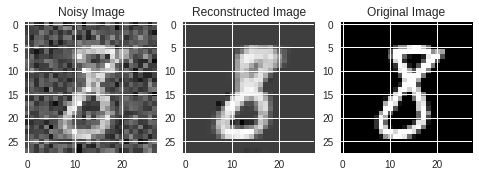

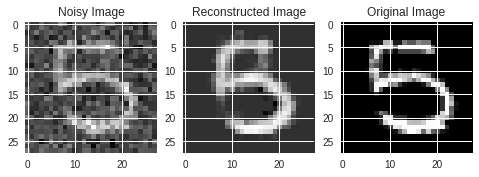

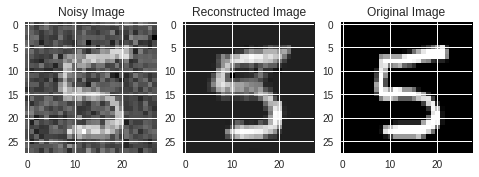

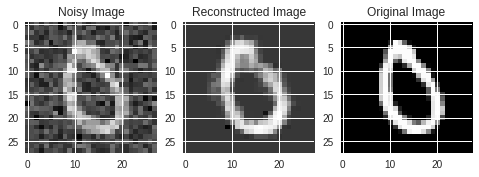

In [87]:



for i in range (10):                         #For 10 random images, test the model.
  output_image = net(input_image)
  output_image=output_image.view(-1,28,28)
  fig = plt.figure()
  plot=fig.add_subplot(1,3,1)
  img = np.array(noisy_image[i])             #Matlab code to display images after denoising.
  plot.set_title('Noisy Image')
  imgplot = plt.imshow(img,cmap='gray')

  plot=fig.add_subplot(1,3, 2)
  img = output_image.data
  plot.set_title('Reconstructed Image')

  img = np.array(img[i])

  imgplot = plt.imshow(img,cmap='gray')
  
  plot=fig.add_subplot(1,3,3)
  img = np.array(test_image[i])
  plot.set_title('Original Image')
  imgplot = plt.imshow(img,cmap='gray')
  plt.show()
  
  
  

In [0]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)